In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from time import sleep
import STLAB_apy as stlab
%matplotlib inline
sns.set_context("notebook", font_scale=1.2)
sns.set_style("white")
colors = stlab.get_led_colors()

# SpectraTune Lab (STLAB, Ledmotive)
### A spectrally tuneable light engine with 10 LED colour channels, capable of generating a broad range of spectral compositions. 

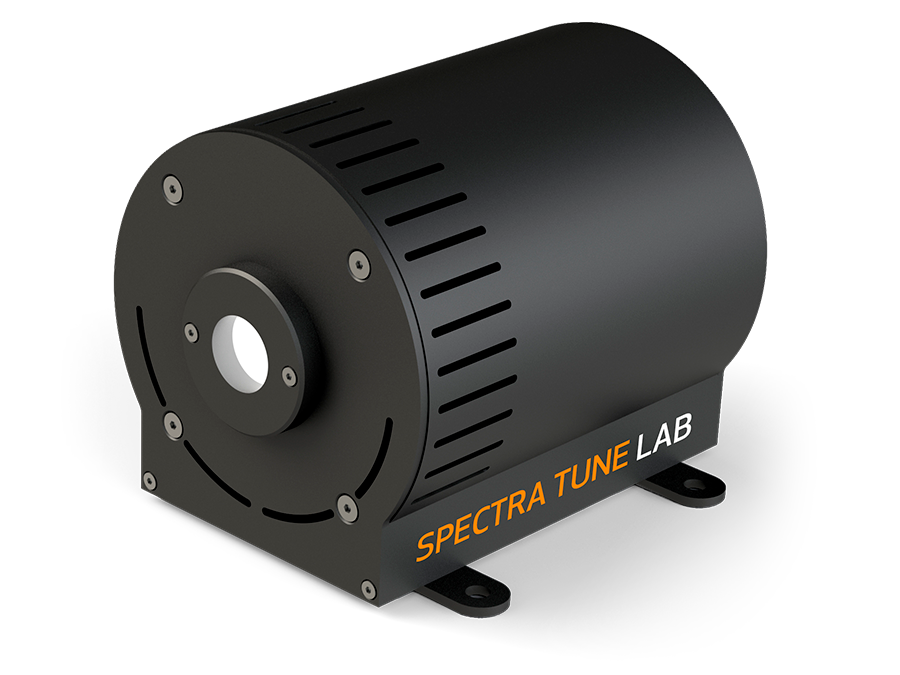

In [2]:
Image(filename='../../../img/STLAB.png', width=300, height=300)

### The STLAB can be controlled programmatically with most languages using its RESTFUL_API, which takes commands via generic http requests. The API includes commands to set a specific spectrum, turn the light off, get readouts from the onboard spectrometer, etc. For this project I am developing a python module which uses the requests library to wrap around useful functions of the RESTFUL_API. It will also include other routines for working with the device. Using this python module, and providing the STLAB is properly connected, we can set up the device as follows. The required password is device-specific.  

In [6]:
device = stlab.setup_device(username='admin', identity=1, password='83e47941d9e930f6')

STLAB device setup complete.


### The **stlab.setup_device** function returns a dictionary object ("device") which must be passed to all future calls to the STLABs underlying API. In the following example, we set each LED in turn to its maximum intensity setting and take a reading from the on-board spectrometer. Note that the intensity of each LED is set with a value between 0 - 4095 (12-bit resolution depth), corresponding to the minimum and maximum input.

In [9]:
leds = [0,1,2,3,4,5,6,7,8,9]
intensity = [4095]
wlbins = np.linspace(380,780,81)

df = pd.DataFrame()
for led in leds:
    spectrum = [0]*10
    spectrum[led] = intensity[0]
    stlab.set_spectrum_a(device, spectrum)
    sleep(.2)
    data = stlab.get_spectrometer_spectrum(device, norm=False)
    data = pd.DataFrame(data)
    data.rename(columns={0:'flux'}, inplace=True)
    df = pd.concat([df, pd.DataFrame(data)])    

# turn the device off
stlab.turn_off(device)

# index for DataFrame
midx = pd.MultiIndex.from_product([leds, intensity, wlbins], names=['led', 'intensity', 'bins'])
df.index = midx
df.reset_index(inplace=True)

### Now, using the data that we just collected, we can plot the spectral power distributions of the 10 channels and their CIE 1931 *xy* chromaticity coordinates, which define the gamut of the device.

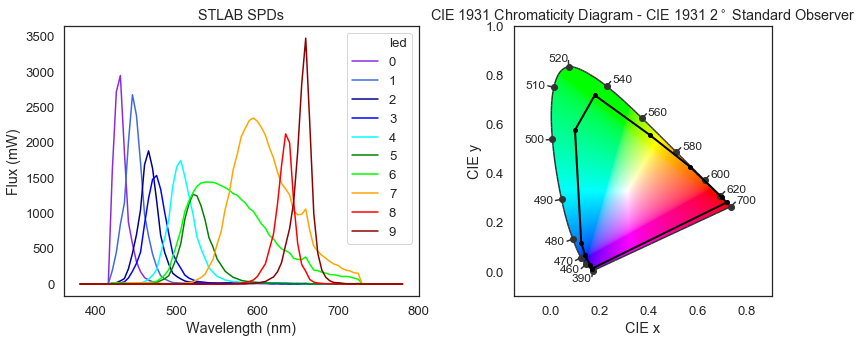

In [10]:
from colour.plotting import plot_chromaticity_diagram_CIE1931

# calculate xy chromaticity coordinates
xy = []
for i, k in df.groupby(by=["led","intensity"]):
    xy.append(stlab.spec_to_xyz(k["flux"].to_numpy()))
xy = pd.DataFrame(xy, columns=["X","Y","Z"])
xy = xy.append(xy.loc[0])

# set up figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# plot SPDs
sns.lineplot(x='bins', y='flux', data=df, hue="led", palette=colors, ax=ax1)
ax1.set_xlabel("Wavelength (nm)")
ax1.set_ylabel("Flux (mW)")
ax1.set_title("STLAB SPDs")

# plotting the *CIE xy* chromaticity coordinates.
plot_chromaticity_diagram_CIE1931(standalone=False, axes=ax2, wrap_title=False)
ax2.set_xlim((-.15,.9))
ax2.set_ylim((-.1,1))
ax2.plot(xy["X"], xy["Y"], color='k', lw=2, marker='o', markersize=4)

f.savefig("../../../data/stlab/spds_gamut.png")

### For a more nuanced understanding of the device, we can sample at a range of intensities, such as from minimum to maximum in steps of 63:

```Python
leds = [0,1,2,3,4,5,6,7,8,9]
intensities = [val for val in range(0,4096,65)]
spectra = stlab.sample_leds(device, leds=leds, intensity=intensities, wait_before_sample=.2)
```

### But this will take about five minutes to run, so let's just load the results from csv.

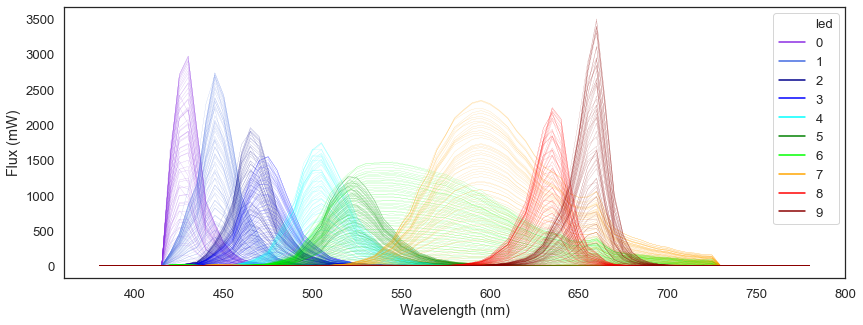

In [24]:
# load existing data
spectra = pd.read_csv("../../../data/led_spectra/led_spectra2.csv")

# set up figure
fig, ax = plt.subplots(figsize=(14,5))

# plot SPDs
sns.lineplot(x='bins', y='flux', data=spectra, hue='led', palette=colors, units='intensity', ax=ax, lw=.1, estimator=None)
ax.set_ylabel("Flux (mW)")
ax.set_xlabel("Wavelength (nm)")

fig.savefig("../../../data/stlab/spds_10_leds_65_spec.png")

### It would be useful to see how the spectral power distributions for each LED vary in terms of *xy* chromaticity, as well as peak wavelength and melanopic irradiance as a function of input

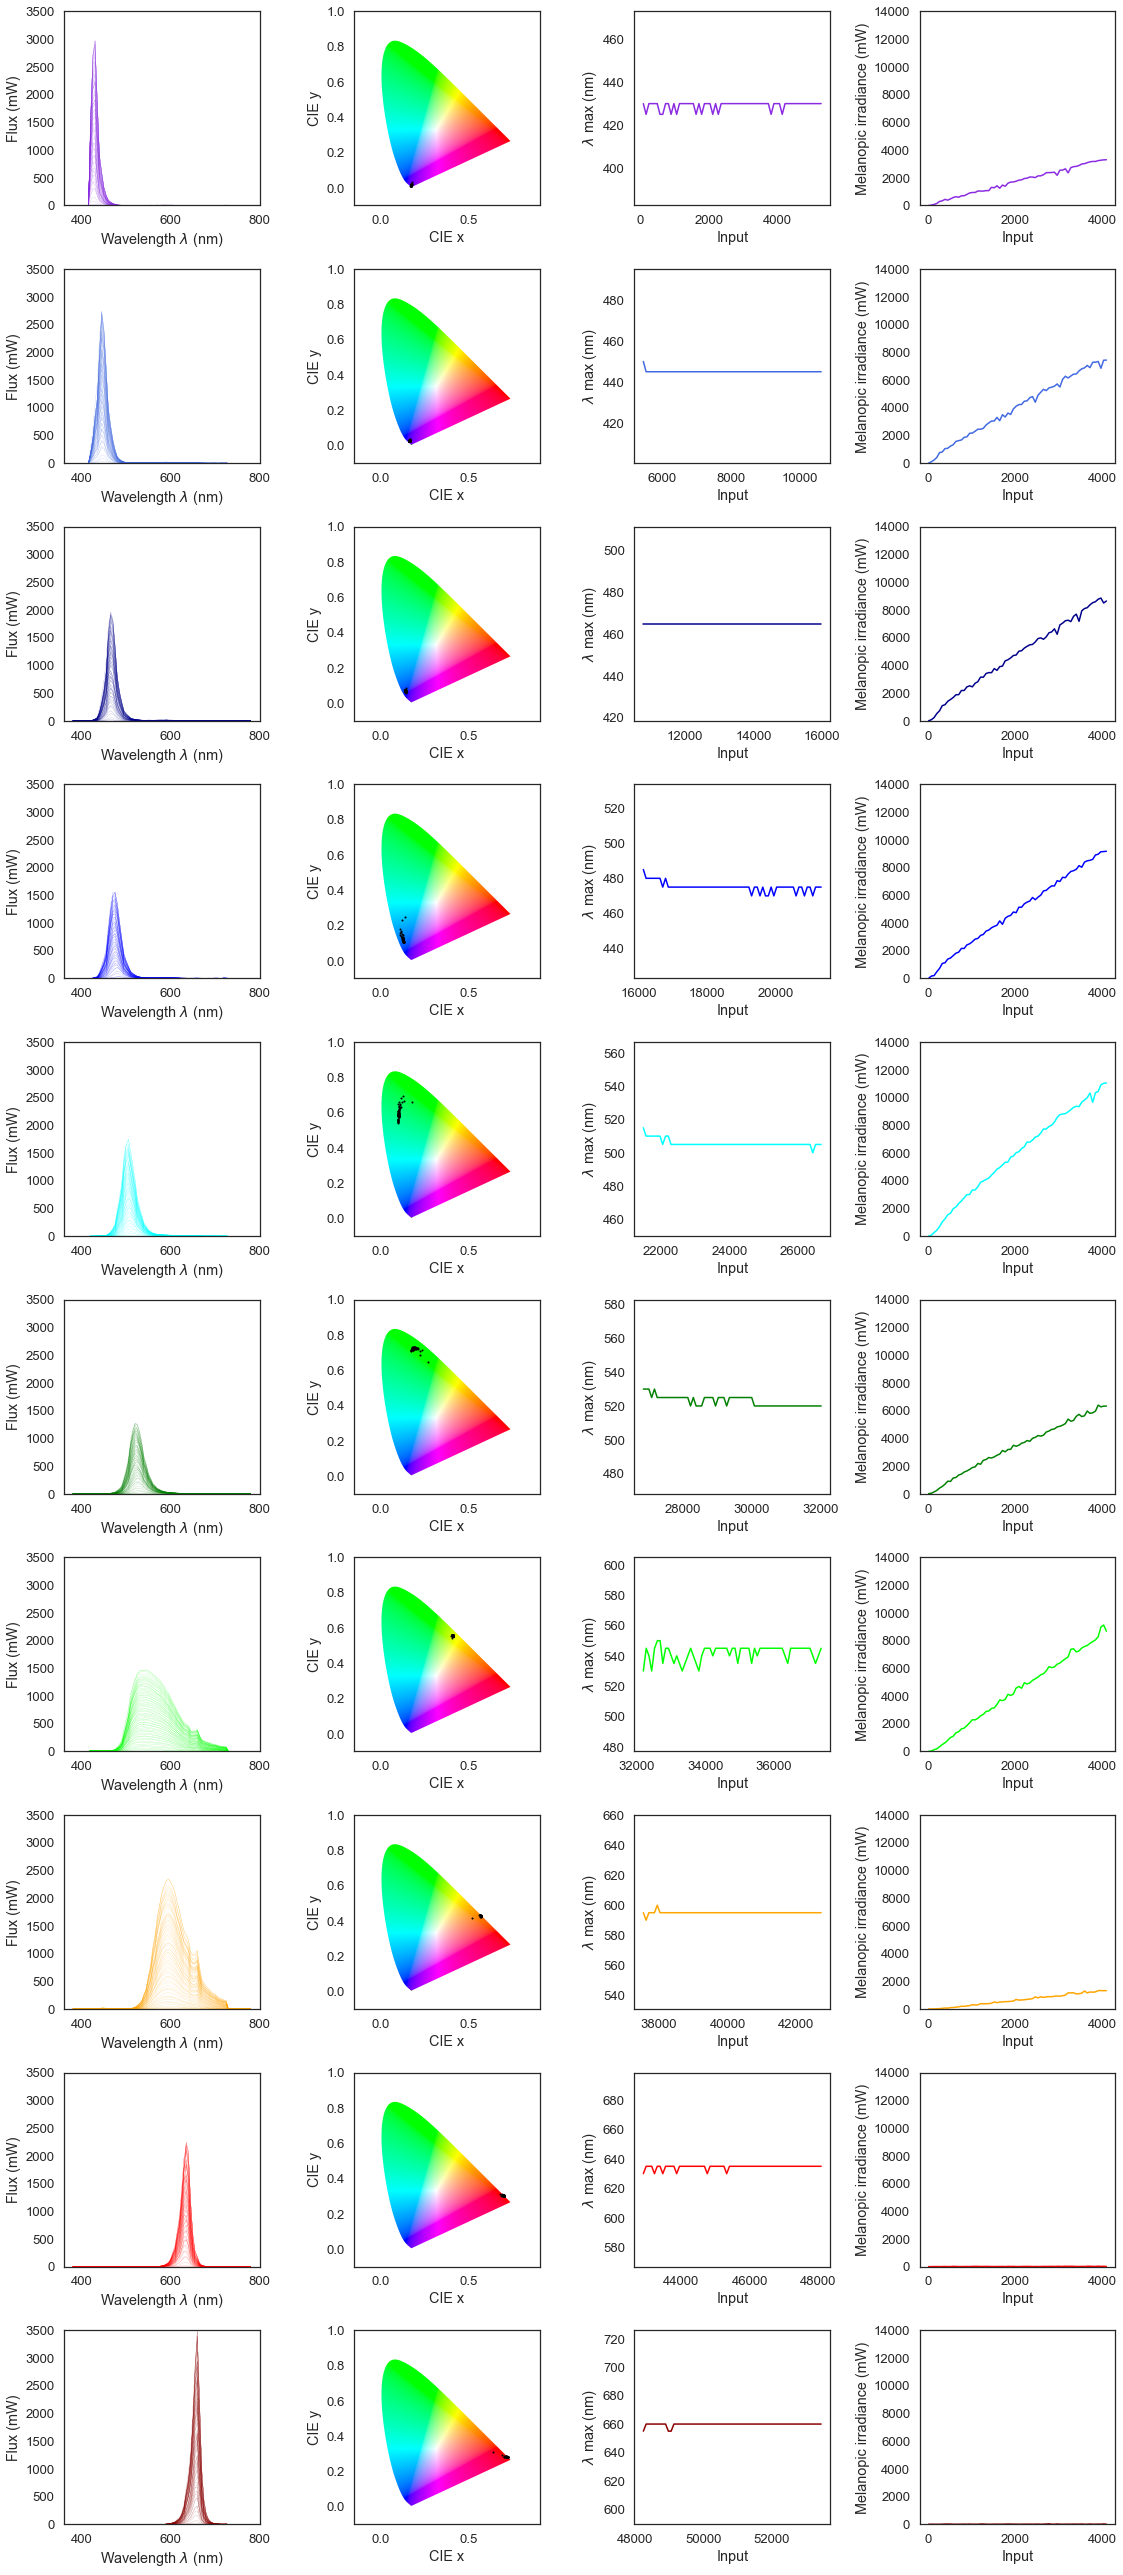

In [43]:
from colour.plotting import plot_chromaticity_diagram_CIE1931
from CIE import get_CIES026, get_CIE_CMF

def peak_wavelength(led_intensity):
    pwl = led_intensity.loc[led_intensity["flux"]==led_intensity["flux"].max()]
    #pwl.set_index('intensity', inplace=True)
    return pwl

spectra = pd.read_csv("../../../data/led_spectra/led_spectra2.csv")
cmf = get_CIE_CMF()
_,sss = get_CIES026(asdf=True)
mel = sss['Mel']
mel = mel[::5]
pwl = spectra.groupby(by=['led','intensity'], as_index=False).apply(peak_wavelength)
pwl.reset_index(drop=True, inplace=True)
pwl

xyz = spectra.groupby(by=["led","intensity"]).agg(
    x   = ("flux", lambda x: np.sum(x  * cmf[1], axis=0)),
    y   = ("flux", lambda x: np.sum(x  * cmf[2], axis=0)),
    z   = ("flux", lambda x: np.sum(x  * cmf[3], axis=0))
    )

xyz["den"] = xyz.sum(axis=1)
xyz.reset_index(inplace=True)
xyz.loc[:,"x"] = xyz.loc[:,"x"] / xyz.loc[:,"den"]
xyz.loc[:,"y"] = xyz.loc[:,"y"] / xyz.loc[:,"den"]
xyz.loc[:,"z"] = xyz.loc[:,"z"] / xyz.loc[:,"den"]

fig , ax = plt.subplots(10, 4, figsize=(16,36))
#spectra.reset_index(inplace=True)
for i, led in enumerate(ax):
                        
    # plot spectra
    sns.lineplot(x='bins', y='flux', data=spectra[spectra.led==i], color=colors[i], units='intensity',ax=ax[i, 0], lw=.1, estimator=None)
    ax[i, 0].set_ylim((0,3500))
    ax[i, 0].set_xlabel("Wavelength $\lambda$ (nm)")
    ax[i, 0].set_ylabel("Flux (mW)")

    # plot color coordinates
    plot_chromaticity_diagram_CIE1931(standalone=False, axes=ax[i, 1], title=False, show_spectral_locus=False)
    ax[i, 1].set_xlim((-.15,.9))
    ax[i, 1].set_ylim((-.1,1))
    ax[i, 1].scatter(xyz.loc[xyz.led==i,"x"][1:], xyz.loc[xyz.led==i,"y"][1:], c='k', s=1)
    
    # plot peak as function of input
    pwl = spectra.loc[spectra.led==i].groupby(by=['intensity'], as_index=False).apply(peak_wavelength)
    pwl.index = pwl.index.droplevel(0)    
    ax[i, 2].plot(pwl.iloc[1:]['bins'], color=colors[i])
    ax[i, 2].set_xlabel("Input")
    ax[i, 2].set_ylim((pwl.iloc[1:]['bins'].min()-pwl.iloc[1:]['bins'].min()*0.1, pwl.iloc[1:]['bins'].max()+pwl.iloc[1:]['bins'].max()*0.1))
    ax[i, 2].set_ylabel("$\lambda$ max (nm)")
    
    # plot melanopic irradience
    new = spectra.loc[spectra.led==i].groupby(by=['intensity'])['flux'].agg(lambda x: x.dot(mel.values.T))
    ax[i, 3].plot(new, color=colors[i])
    ax[i, 3].set_ylim((0,14000))
    ax[i, 3].set_xlabel("Input")
    ax[i, 3].set_ylabel("Melanopic irradiance (mW)")

### Now, using linear interpolation on these data we can create a lookup table to predict the spectral power distribution for each primary at all intensity levels between 0 and 4095. This can be thought of as the forward model of the device.

In [28]:
spectra = pd.read_csv("../../../data/led_spectra/led_spectra2.csv", index_col=['led','intensity','bins'])
tbl = spectra.unstack(level=2)
tbl.columns = [val[1] for val in tbl.columns]

# next tep...

lkp_tbl = pd.DataFrame()
for led, df in lkp.groupby(["led"]):
    intensities = df.index.get_level_values('intensity')
    new_intensities = np.linspace(intensities.min(), intensities.max(), 4096)
    new_intensities = new_intensities.astype('int')
    df.reset_index(inplace=True, drop=True)
    df.columns = range(0, df.shape[1])
    df.index = df.index * 63
    n = df.reindex(new_intensities).interpolate(method='linear')
    n['intensity'] = n.index
    n['led'] = led
    lkp_tbl = lkp_tbl.append(n)

lkp_tbl.set_index(['led','intensity'], inplace=True)
#new.to_csv("../../../data/led_spectra/test.csv")

### Using this lookup table we can predict the spectrum for any combination of LED intensity settings and, if the STLAB is still connected, compare it to a readout from the spectrometer. Let's do this a few times.

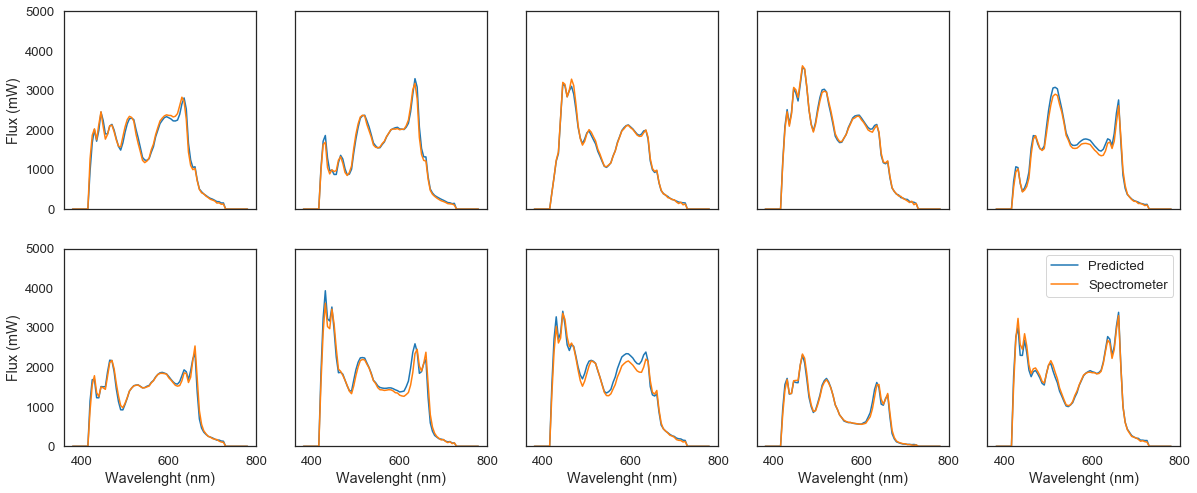

In [31]:
import random

# set up fgiure
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,8), sharey=True, sharex=True)
axs = [ax for sublist in axs for ax in sublist]

# predict, measure and plot for 8 random inputs
for ax in axs:
    random_input = [random.randrange(4096) for led in range(10)]
    predicted_spectrum = stlab.predicted_spd(random_input, lkp_table=lkp_tbl)
    stlab.set_spectrum_a(device, random_input)
    measured_spectrum = stlab.get_spectrometer_spectrum(device, norm=False)
    stlab.turn_off(device)
    ax.plot(wlbins, predicted_spectrum, label="Predicted")
    ax.plot(wlbins, measured_spectrum, label='Spectrometer')
    ax.set_ylim((0,5000))
    
for ax in [axs[0], axs[5]]:
    ax.set_ylabel("Flux (mW)")

for ax in axs[5:]:
    ax.set_xlabel("Wavelenght (nm)")

ax.legend()


### Looks like the predictions are fairly accurate.